# 0. SETUP

## 0.1. Módulos comuns

In [1]:
from numpy import *
from numpy.linalg import *
from matplotlib.pyplot import *
from matplotlib.collections import PatchCollection

from scipy.optimize import minimize

## 0.2. Parâmetros do problema

In [2]:
SCALE = 1.0 # How much each screen element is going to be scaled. Default is 1.0
SCREEN_HEIGHT = 30 # The height of the screen that contains the overlapping windows in pixels
SCREEN_WIDTH = 30 # The width of the screen that contains the overlapping windows in pixels
MAX_WINDOW_DIM = 3 # The max height or width each window can have. For the project the default is 3.
MIN_WINDOW_DIM = 2 # The minimum height or width each window can have. For the project the default is 2.
CLUSTER_DISTANCE_FROM_SCREEN_CENTER = 8 # The distance from the clusters to the screen center in pixels
POINT_DISTANCE_FROM_CLUSTER = 5 # How far the points can be from the cluster in pixels
KNN_K = 10 # The number of closest neighbors considered for building the connectivity graph

## 0.3. Preprocessamento dos parâmetros

In [3]:
# Rescale
SCREEN_HEIGHT *= SCALE
SCREEN_WIDTH *= SCALE
MAX_WINDOW_DIM *= SCALE
MIN_WINDOW_DIM *= SCALE
CLUSTER_DISTANCE_FROM_SCREEN_CENTER *= SCALE
POINT_DISTANCE_FROM_CLUSTER *= SCALE

SCREEN_CENTER = array([ floor(SCREEN_WIDTH/2), floor(SCREEN_HEIGHT/2) ])

# 1. PREPARAÇÃO DOS DADOS

Os vetores $P_j$ gerados possuem dimensão $4$: a posição $x$ e $y$ (coluna) da origem do retângulo (ponto superior esquerdo), a altura do retângulo $h$ e a largura $w$, de forma que $P_j=(x_j,y_j,h_j,w_j)$. A nivel de implementação, o ponto ainda possui a informação do cluster ao qual ele pertence.

## 1.1 Gerar Centros

In [4]:
n_groups = random.randint(3,7)
angle_between_points = (2.0 * pi / n_groups * arange(0 , n_groups)) # The array of the angle of each cluster w.r.t. the x-axis

clusters = transpose( # Each row is a pair x,y from each cluster
    array( [
        CLUSTER_DISTANCE_FROM_SCREEN_CENTER * cos( angle_between_points ) + SCREEN_CENTER[0],
        CLUSTER_DISTANCE_FROM_SCREEN_CENTER * sin( angle_between_points ) + SCREEN_CENTER[1]
    ] )
)

## 1.2 Gerar pontos ao redor dos centros

In [5]:
size_groups = random.randint(5, 16, n_groups)
points = zeros((sum(size_groups),5)) #

j = 0
for cluster_idx in range(n_groups):
    for idx in range(size_groups[cluster_idx]):
        # Point position
        points[j,:2] = clusters[cluster_idx] + random.randint(-POINT_DISTANCE_FROM_CLUSTER/2,POINT_DISTANCE_FROM_CLUSTER/2, 2)
        # Point dimension
        points[j,2:4] = random.randint(MIN_WINDOW_DIM,MAX_WINDOW_DIM+1,2)
        # cluster_information
        points[j,4] = cluster_idx
        j += 1
        
points_pos = points[:,:2] # position vectors
points_dims = points[:,2:4] # dimension vectors

## 1.3 Mostrar os dados

<Figure size 432x288 with 0 Axes>

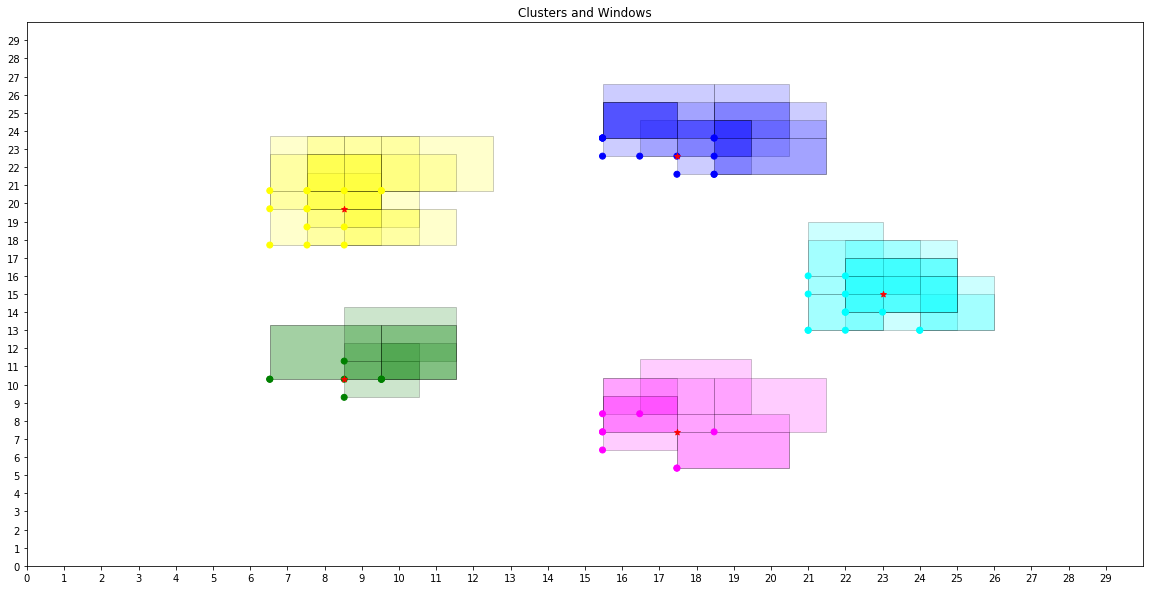

In [6]:
def draw_windows(window_clusters, window_points, window_dims, window_cluster_ids, n_clusters, group_size_list):
    clf()
    fig, ax = subplots(1, figsize=(20,10))
    ax.set_title("Clusters and Windows")
    ax.set_xlim(0, SCREEN_WIDTH)
    ax.set_ylim(0, SCREEN_HEIGHT)
    ax.set_xticks(arange(0, SCREEN_WIDTH, 1 * SCALE))
    ax.set_yticks(arange(0, SCREEN_HEIGHT, 1 * SCALE))
    
    # Draw Rectangles
    rect_clusters_list = [[] for i in range(n_clusters)]
    for j in range(sum(group_size_list)):
        point = window_points[j]
        dim = window_dims[j]
        idx = window_cluster_ids[j]
        rect = Rectangle((point[0], point[1]), dim[0], dim[1])
        rect_clusters_list[int(idx)].append(rect)
    color_list = ["cyan", "blue", "yellow", "green", "magenta", "gray", "black"]
    for i in range(n_clusters):
        rect_list = rect_clusters_list[i]
        pc = PatchCollection(rect_list, facecolor=color_list[i], edgecolor="k", alpha=0.2)
        ax.add_collection(pc)
        
    # Plot points
    colors_idx=window_cluster_ids[:].astype('int32')
    colors = [ color_list[color_idx] for color_idx in colors_idx]
    scatter(window_points[:,0], window_points[:,1], c=colors)

    # Plot Clusters
    ax.scatter(window_clusters[:,0], window_clusters[:,1], c="red", marker="*")
    return

draw_windows(clusters, points_pos, points_dims, points[:,4], n_groups, size_groups)

# 2. Modelagem Matemática


O problema se resume a maximizar $E(X) = (1-\alpha) E_O(X) + \alpha E_N(X) $, em que $X=(x_j, y_j)$ e $\alpha \in [0,1]$. $E_0$ e $E_N$ são as funções de energia de overlap e a de relação entre os vizinhos. Mais detalhes sobre as funções podem ser encontradas [neste link](https://ieeexplore.ieee.org/abstract/document/6629989).

In [7]:
def plus_operator(val):
    if val > 0:
        return val
    return 0.0

def O_ij(s_i, delta_s_i, s_j, delta_s_j):
    ret_val = 0
    if(s_i >= s_j):
        ret_val =  (1./(delta_s_j ** 4)) * plus_operator(delta_s_j ** 2 - (s_i - s_j) ** 2) ** 2
    else:
        ret_val =  (1./(delta_s_i ** 4)) * plus_operator(delta_s_i ** 2 - (s_i - s_j) ** 2) ** 2
    return ret_val

def connection_graph(X):
    N = X.shape[0]
    G = zeros((N,N))
    for from_idx in range(N):
        # Compute the distance from point p_from to the other points
        p_from = X[from_idx]
        dist_list = zeros((N))
        for for_idx in range(from_idx+1, N):
            p_for = X[for_idx]
            dist_list[for_idx] = linalg.norm(p_from - p_for)
        # Find the indices of the closest K points to p_from
        closest_ids = argsort(dist_list)[:KNN_K]
        # Connect them in the graph (connection value is their distance, which is != 0)
        for idx in closest_ids:
            G[from_idx, idx] = 1.0
            G[idx, from_idx] = 1.0
    return G

def laplacian_graph(G):
    N = G.shape[0]
    L = zeros((N,N))
    for from_idx in range(N):
        for for_idx in range(N):
            # Points are different and connected
            if(from_idx != for_idx and G[from_idx, for_idx] != 0):
                degree = 0.0
                for idx in range(N):
                    if(G[from_idx, idx] != 0):
                        degree += 1.0
                L[from_idx, for_idx] = -1./(1.0 * degree)
            # Same points
            elif(from_idx == for_idx):
                L[from_idx, for_idx] = 1.0
            # Different points and disconnected
            else:
                L[from_idx, for_idx] = 0.0
    return L

In [8]:
def E_O(X):
    X = reshape(X[:-1], (points.shape[0], 2)) # Remove w from the state
    sum_e = 0
    n = X.shape[0]
    for i in range(n):
        point_i = X[i]
        # Horizontal
        x_i = point_i[0]
        h_i = points_dims[i,0]
        # Vertical
        y_i = point_i[1]
        v_i = points_dims[i,1]
        for j in range(i+1,X.shape[0]):
            point_j = X[j]
            # Horizontal
            x_j = point_j[0]
            h_j = points_dims[j,0]
            overlapping_h = O_ij(x_i, h_i, x_j, h_j)
            # Vertical
            y_j = point_j[1]
            v_j = points_dims[j,1]
            overlapping_v = O_ij(y_i, v_i, y_j, v_j)
            # Sum
            sum_e += overlapping_h * overlapping_v
    sum_e = 2.0 / (n * (n+1) ) * sum_e
    return 100 * sum_e

def E_N(X):
    N = points.shape[0]
    w = X[-1]
    X = reshape(X[:-1], (points.shape[0], 2)) # Remove w from the state
    # Build connectivy graph G, where the closest k points are connected (nothing related to class was addressed)
    G = connection_graph(X)
    # Build the Laplacian graph
    L = laplacian_graph(G)
    delta_x = L.dot(points_pos[:,0])
    delta_y = L.dot(points_pos[:,1])
    norm_factor = (N ** 2.0)/( 2.0 * (linalg.norm(delta_x) ** 2 +linalg.norm(delta_y) ** 2) )
    diff_x = linalg.norm( L.dot(X[:,0]) - w * delta_x ) ** 2
    diff_y = linalg.norm(L.dot(X[:,1]) - w * delta_y) ** 2 
    diff_factor = ( diff_x + diff_y)
    sum_e = norm_factor * diff_factor
    return sum_e

def E_N_new(X):
    N = points.shape[0]
    X = reshape(X[:-1], (points.shape[0], 2)) # Remove w from the state
    G = connection_graph(X)
    energy = 0.0
    for i in range(N):
        label_i = points[i,4]
        sum_e = 0.0
        # Check how many of the closest neighbors of X_i belong to the same cluster
        for j in range(N):
            label_j = points[j,4]
            if(G[i,j] != 0 and label_i == label_j):
                sum_e += 1.0
        energy += 1.0 - (sum_e * 1.0)/ (N * 1.0)
    return energy


# 3. Solução Numérica

In [12]:
alpha = 0.2
def f (x):
    e_n = E_N(x)
    e_o = E_O(x)
    
    print("E_N(X)={} | E_O(X)={}".format(e_n, e_o) )
    return alpha * e_n + (1- alpha) * e_o

## RESTRICOES
#### ATENCAO: AS RESTRICOES DE DESIGUALDADE NO SCIPY SAO O OPOSTO: SAO DO TIPO r(X) >= 0!
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize
x_min = 0
x_max = SCREEN_WIDTH
y_min = 0
y_max = SCREEN_HEIGHT

# r1: x_min-x_i <= 0 
#     <=> x_i - x_min >= 0
def constr_fun_1(X):
    """
    X is the matrix (N,2) of points.
    """
    X = reshape(X[:-1], (points.shape[0], 2)) # Remove w from the state
    N = X.shape[0]
    constr = zeros((N))
    for i in range(N):
        #constr[i] = x_min - X[i,0]
        constr[i] = X[i,0] - x_min
    return constr

# r2: x_i - x_max + h_i <= 0 
#     <=> x_max - x_i - h_i >= 0
def constr_fun_2(X):
    """
    X is the matrix (N,2) of points.
    """
    X = reshape(X[:-1], (points.shape[0], 2)) # Remove w from the state
    N = X.shape[0]
    constr = zeros((N))
    for i in range(N):
        #constr[i] = - x_max + X[i,0] + points_dims[i,0]
        constr[i] = x_max - X[i,0] - points_dims[i,0] - 1
    return constr

# r3: y_min-y_i <= 0 
#     <=> y_i - y_min >= 0
def constr_fun_3(X):
    """
    X is the matrix (N,2) of points.
    """
    X = reshape(X[:-1], (points.shape[0], 2)) # Remove w from the state
    N = X.shape[0]
    constr = zeros((N))
    for i in range(N):
        constr[i] = X[i,1] -  y_min
        #constr[i] = -X[i,1] + y_min
    return constr

# r4: y_i - y_max + v_i <= 0
#     <=> y_max - y_i - v_i >= 0
def constr_fun_4(X):
    """
    X is the matrix (N,2) of points.
    """
    X = reshape(X[:-1], (points.shape[0], 2)) # Remove w from the state
    N = X.shape[0]
    constr = zeros((N))
    for i in range(N):
        constr[i] = x_max - X[i,1]  - points_dims[i,1] - 1
        #constr[i] = - x_max + X[i,1]  + points_dims[i,1]
    return constr


cons = (
    {'type': 'ineq', 'fun':  constr_fun_1},
    {'type': 'ineq', 'fun':  constr_fun_2},
    {'type': 'ineq', 'fun':  constr_fun_3},
    {'type': 'ineq', 'fun':  constr_fun_4},
)

bounds = []
for idx in range(points_pos.shape[0]):
    point_bound_x = (x_min, x_max - points_dims[idx,0]-1)
    point_bound_y = (y_min, y_max - points_dims[idx,1]-1)
    bounds.append(point_bound_x)
    bounds.append(point_bound_y)
    
w_init = 0.5
X_init = append(points_pos.flatten(), [w_init])
res = minimize(f, X_init , method='SLSQP', constraints=cons, tol=1e-5, options={"maxiter" : 5e1})
X_final = reshape(res["x"][:-1], (points.shape[0], 2))

E_N(X)=392.0 | E_O(X)=5.798893898925319
E_N(X)=392.0 | E_O(X)=5.798893898925319
E_N(X)=392.0000000296102 | E_O(X)=5.798893898624558
E_N(X)=392.0000000571345 | E_O(X)=5.798893901148676
E_N(X)=392.00000001442066 | E_O(X)=5.798893897292319
E_N(X)=392.00000000044065 | E_O(X)=5.7988938999675765
E_N(X)=391.99999999249246 | E_O(X)=5.79889390080722
E_N(X)=392.00000000044065 | E_O(X)=5.798893900106977
E_N(X)=391.99999999249246 | E_O(X)=5.798893900451696
E_N(X)=392.00000002236885 | E_O(X)=5.798893897643881
E_N(X)=392.0000000007256 | E_O(X)=5.7988938980474805
E_N(X)=392.0000000158211 | E_O(X)=5.798893896647208
E_N(X)=392.0000000067112 | E_O(X)=5.798893898499733
E_N(X)=392.0000000009611 | E_O(X)=5.798893897653607
E_N(X)=392.00000000962183 | E_O(X)=5.798893897443068
E_N(X)=392.00000000128216 | E_O(X)=5.798893898718134
E_N(X)=392.00000000145917 | E_O(X)=5.798893898463089
E_N(X)=391.99999999396044 | E_O(X)=5.798893899005837
E_N(X)=391.99999999594826 | E_O(X)=5.798893901501518
E_N(X)=391.9999999883733

E_N(X)=3.159072961472656e-05 | E_O(X)=5.799060396226858
E_N(X)=3.15907223854368e-05 | E_O(X)=5.79906039945775
E_N(X)=3.159072054259908e-05 | E_O(X)=5.7990603993927925
E_N(X)=3.15907299597739e-05 | E_O(X)=5.799060398093417
E_N(X)=3.1590718936787125e-05 | E_O(X)=5.799060399655853
E_N(X)=3.159073091259473e-05 | E_O(X)=5.7990603995152865
E_N(X)=3.1590722711736675e-05 | E_O(X)=5.799060396492225
E_N(X)=3.159073521891511e-05 | E_O(X)=5.799060399158254
E_N(X)=3.159071373417908e-05 | E_O(X)=5.799060398546809
E_N(X)=3.159073227431683e-05 | E_O(X)=5.7990603993202825
E_N(X)=3.159071539403012e-05 | E_O(X)=5.799060398455459
E_N(X)=3.159073796741669e-05 | E_O(X)=5.799060396564665
E_N(X)=3.1590717138460805e-05 | E_O(X)=5.799060398455863
E_N(X)=3.159073579628854e-05 | E_O(X)=5.799060396565656
E_N(X)=3.1590720445126795e-05 | E_O(X)=5.799060398241607
E_N(X)=3.1590731880123984e-05 | E_O(X)=5.799060397084589
E_N(X)=3.159071455061656e-05 | E_O(X)=5.79906039713444
E_N(X)=3.1590715931482196e-05 | E_O(X)=5.799

E_N(X)=0.19852039695742085 | E_O(X)=5.266015154885047
E_N(X)=0.19852039761584267 | E_O(X)=5.2660151549951735
E_N(X)=0.19852039684196238 | E_O(X)=5.266015155626438
E_N(X)=0.19852039767753898 | E_O(X)=5.266015155084581
E_N(X)=0.19852039565119292 | E_O(X)=5.266015157330461
E_N(X)=0.19852039721562617 | E_O(X)=5.266015155590184
E_N(X)=0.19852039627653872 | E_O(X)=5.266015156281754
E_N(X)=0.19852039576304345 | E_O(X)=5.266015157293914
E_N(X)=0.19852039637959074 | E_O(X)=5.266015156178088
E_N(X)=0.19852039631448176 | E_O(X)=5.266015156850641
E_N(X)=0.19852039493748416 | E_O(X)=5.266015158461383
E_N(X)=0.1985203956631844 | E_O(X)=5.266015157552268
E_N(X)=0.19852039631093343 | E_O(X)=5.26601515628362
E_N(X)=0.19852039570411914 | E_O(X)=5.266015157293994
E_N(X)=0.19852039660817317 | E_O(X)=5.266015156178301
E_N(X)=0.19852039633109103 | E_O(X)=5.266015156343603
E_N(X)=0.19852039807245275 | E_O(X)=5.266015154195074
E_N(X)=0.19852039722867335 | E_O(X)=5.266015155048094
E_N(X)=0.1985203965973247 | E

E_N(X)=3.0523230883262276 | E_O(X)=3.8034806420394562
E_N(X)=3.0523230883262276 | E_O(X)=3.8034806420394562
E_N(X)=3.052323087901288 | E_O(X)=3.8034806418896916
E_N(X)=3.052323080294482 | E_O(X)=3.80348064408738
E_N(X)=3.052323092847499 | E_O(X)=3.8034806410434774
E_N(X)=3.0523230846147555 | E_O(X)=3.8034806429376955
E_N(X)=3.0523230829881802 | E_O(X)=3.8034806433363375
E_N(X)=3.0523230849353555 | E_O(X)=3.8034806424743945
E_N(X)=3.052323083808153 | E_O(X)=3.8034806431812487
E_N(X)=3.0523230910387875 | E_O(X)=3.803480641339042
E_N(X)=3.0523230910644674 | E_O(X)=3.8034806411292967
E_N(X)=3.052323094538549 | E_O(X)=3.8034806402608217
E_N(X)=3.052323089879019 | E_O(X)=3.8034806417001104
E_N(X)=3.052323092050336 | E_O(X)=3.8034806409835786
E_N(X)=3.0523230931097736 | E_O(X)=3.803480640590192
E_N(X)=3.052323089188968 | E_O(X)=3.8034806414112587
E_N(X)=3.0523230893160296 | E_O(X)=3.803480641834632
E_N(X)=3.052323087126524 | E_O(X)=3.803480642291273
E_N(X)=3.0523230804239385 | E_O(X)=3.803480

E_N(X)=3.069886689097756 | E_O(X)=3.7657856139768993
E_N(X)=3.069886684590478 | E_O(X)=3.7657856148382254
E_N(X)=3.06988668504333 | E_O(X)=3.7657856149969207
E_N(X)=3.0698866923158885 | E_O(X)=3.765785612921463
E_N(X)=3.069886685941423 | E_O(X)=3.7657856147316657
E_N(X)=3.0698866852140627 | E_O(X)=3.765785614952159
E_N(X)=3.0698866836806387 | E_O(X)=3.7657856157868346
E_N(X)=3.0698866876798916 | E_O(X)=3.765785614044643
E_N(X)=3.0698866937584643 | E_O(X)=3.765785612542262
E_N(X)=3.069886687765047 | E_O(X)=3.7657856140463806
E_N(X)=3.069886693427357 | E_O(X)=3.7657856125153226
E_N(X)=3.06988668779069 | E_O(X)=3.7657856139931867
E_N(X)=3.0698866906520856 | E_O(X)=3.76578561333333
E_N(X)=3.0698866914896543 | E_O(X)=3.765785613072855
E_N(X)=3.0698866890352527 | E_O(X)=3.7657856136601544
E_N(X)=3.069886690475354 | E_O(X)=3.765785613956839
E_N(X)=3.069886691333078 | E_O(X)=3.7657856138301784
E_N(X)=3.0698866898898984 | E_O(X)=3.765785613753499
E_N(X)=3.0698866858204874 | E_O(X)=3.76578561458

E_N(X)=3.5792541755413994 | E_O(X)=3.543161368465322
E_N(X)=3.5792541726583686 | E_O(X)=3.543161369462333
E_N(X)=3.5792541765481865 | E_O(X)=3.543161368599615
E_N(X)=3.5792541745629225 | E_O(X)=3.5431613690939856
E_N(X)=3.579254171370396 | E_O(X)=3.5431613699493285
E_N(X)=3.5792541723430427 | E_O(X)=3.5431613695125783
E_N(X)=3.5792541761772814 | E_O(X)=3.543161368690745
E_N(X)=3.579254172627886 | E_O(X)=3.543161369457617
E_N(X)=3.579254176279433 | E_O(X)=3.543161368669814
E_N(X)=3.579254175565182 | E_O(X)=3.543161368658158
E_N(X)=3.579254183415289 | E_O(X)=3.543161367071451
E_N(X)=3.5792541786553347 | E_O(X)=3.5431613679560283
E_N(X)=3.579254174445468 | E_O(X)=3.5431613690100727
E_N(X)=3.5792541796095563 | E_O(X)=3.543161367788742
E_N(X)=3.5792541754431357 | E_O(X)=3.543161368863578
E_N(X)=3.5792541796095607 | E_O(X)=3.543161367788741
E_N(X)=3.57925417544314 | E_O(X)=3.543161368863578
E_N(X)=3.5792541744823057 | E_O(X)=3.543161368628279
E_N(X)=3.5792541770507356 | E_O(X)=3.543161368665

E_N(X)=3.9956081189553996 | E_O(X)=3.371868578458543
E_N(X)=3.9956081246378936 | E_O(X)=3.371868577131664
E_N(X)=3.9956081208416334 | E_O(X)=3.3718685778819966
E_N(X)=3.995608126722139 | E_O(X)=3.3718685762157934
E_N(X)=3.995608128846176 | E_O(X)=3.3718685761436413
E_N(X)=3.9956081312976868 | E_O(X)=3.3718685754383317
E_N(X)=3.995608125797758 | E_O(X)=3.3718685767167806
E_N(X)=3.9956081286110003 | E_O(X)=3.3718685762048555
E_N(X)=3.9956081317325807 | E_O(X)=3.3718685754725115
E_N(X)=3.9956081299924935 | E_O(X)=3.3718685758362996
E_N(X)=3.9956081255824443 | E_O(X)=3.3718685765283927
E_N(X)=3.9956081246181956 | E_O(X)=3.3718685767057224
E_N(X)=3.995608118324289 | E_O(X)=3.371868578669717
E_N(X)=3.9956081241050447 | E_O(X)=3.3718685775406314
E_N(X)=3.9956081182047893 | E_O(X)=3.3718685784142624
E_N(X)=3.9956081275331226 | E_O(X)=3.3718685763457907
E_N(X)=3.9956081324987376 | E_O(X)=3.3718685752127358
E_N(X)=3.995608125471479 | E_O(X)=3.371868577062862
E_N(X)=3.9956081242517145 | E_O(X)=3.

E_N(X)=4.245177528536859 | E_O(X)=3.302191221954727
E_N(X)=4.245177522698066 | E_O(X)=3.302191222682418
E_N(X)=4.245177533822618 | E_O(X)=3.3021912212012046
E_N(X)=4.245177537022833 | E_O(X)=3.3021912200208363
E_N(X)=4.245177533508424 | E_O(X)=3.302191221186707
E_N(X)=4.245177537817661 | E_O(X)=3.3021912199709265
E_N(X)=4.245177534117375 | E_O(X)=3.3021912208158004
E_N(X)=4.245177534652727 | E_O(X)=3.302191220492765
E_N(X)=4.245177539996932 | E_O(X)=3.3021912199457444
E_N(X)=4.2451775352484695 | E_O(X)=3.302191220875593
E_N(X)=4.245177531873818 | E_O(X)=3.302191221395015
E_N(X)=4.24517753019259 | E_O(X)=3.3021912211891644
E_N(X)=4.245177535213249 | E_O(X)=3.302191220767182
E_N(X)=4.245177533707003 | E_O(X)=3.3021912211344775
E_N(X)=4.245177528923442 | E_O(X)=3.302191222328617
E_N(X)=4.24517752860025 | E_O(X)=3.3021912221666563
E_N(X)=4.245177528099735 | E_O(X)=3.302191222471455
E_N(X)=4.24517753673194 | E_O(X)=3.30219122027985
E_N(X)=4.2451775349452205 | E_O(X)=3.30219122065297
E_N(X)=

E_N(X)=3.9528861991451945 | E_O(X)=3.3113103526670122
E_N(X)=3.9528862037481662 | E_O(X)=3.3113103510115263
E_N(X)=3.9528862010793153 | E_O(X)=3.311310351900575
E_N(X)=3.952886196137441 | E_O(X)=3.311310353011396
E_N(X)=3.9528862011405788 | E_O(X)=3.3113103518745017
E_N(X)=3.9528861959248163 | E_O(X)=3.3113103530397083
E_N(X)=3.9528862011405876 | E_O(X)=3.3113103518745004
E_N(X)=3.952886195924815 | E_O(X)=3.311310353039708
E_N(X)=3.9528861978641827 | E_O(X)=3.31131035278638
E_N(X)=3.9528861981281844 | E_O(X)=3.3113103526701297
E_N(X)=3.9528861989461888 | E_O(X)=3.3113103523828986
E_N(X)=3.9528861984059103 | E_O(X)=3.3113103525805974
E_N(X)=3.9528861957247012 | E_O(X)=3.3113103532413457
E_N(X)=3.9528861971067095 | E_O(X)=3.311310353144322
E_N(X)=3.9528862003017378 | E_O(X)=3.311310351930534
E_N(X)=3.9528862008073498 | E_O(X)=3.311310352084103
E_N(X)=3.952886194391742 | E_O(X)=3.3113103534943082
E_N(X)=3.952886202141927 | E_O(X)=3.3113103515090345
E_N(X)=3.9528861981392223 | E_O(X)=3.311

E_N(X)=3.8223116946172806 | E_O(X)=3.230554343968669
E_N(X)=3.8223116977854 | E_O(X)=3.2305543432716592
E_N(X)=3.8223116956725103 | E_O(X)=3.230554344150675
E_N(X)=3.8223117019672084 | E_O(X)=3.230554342504275
E_N(X)=3.8223117061474143 | E_O(X)=3.2305543411314828
E_N(X)=3.8223116999126443 | E_O(X)=3.2305543430005255
E_N(X)=3.822311701762912 | E_O(X)=3.2305543425991567
E_N(X)=3.8223116952041063 | E_O(X)=3.2305543437915585
E_N(X)=3.822311701654684 | E_O(X)=3.230554342432922
E_N(X)=3.822311699085472 | E_O(X)=3.2305543430148504
E_N(X)=3.8223117058724787 | E_O(X)=3.230554341687733
E_N(X)=3.822311702291152 | E_O(X)=3.2305543422040297
E_N(X)=3.8223117002332363 | E_O(X)=3.23055434291199
E_N(X)=3.8223116961853605 | E_O(X)=3.230554343788357
E_N(X)=3.8223117008488963 | E_O(X)=3.230554342978684
E_N(X)=3.8223117047493704 | E_O(X)=3.2305543420091407
E_N(X)=3.822311698858641 | E_O(X)=3.2305543439297244
E_N(X)=3.8223117029403633 | E_O(X)=3.2305543420783964
E_N(X)=3.8223117039556103 | E_O(X)=3.23055434

E_N(X)=4.05465105807197 | E_O(X)=3.109521668588873
E_N(X)=4.054651056340713 | E_O(X)=3.1095216690311878
E_N(X)=4.054651065794921 | E_O(X)=3.109521666866434
E_N(X)=4.054651064037449 | E_O(X)=3.10952166732904
E_N(X)=4.054651066211673 | E_O(X)=3.1095216663456986
E_N(X)=4.054651066510593 | E_O(X)=3.1095216667277974
E_N(X)=4.054651062242507 | E_O(X)=3.109521667772945
E_N(X)=4.054651062731638 | E_O(X)=3.1095216676913986
E_N(X)=4.054651053690927 | E_O(X)=3.1095216687689398
E_N(X)=4.054651063332879 | E_O(X)=3.1095216675749207
E_N(X)=4.054651060240173 | E_O(X)=3.109521668181786
E_N(X)=4.054651056566203 | E_O(X)=3.1095216693740935
E_N(X)=4.054651060826866 | E_O(X)=3.1095216677757076
E_N(X)=4.054651061218633 | E_O(X)=3.1095216678346103
E_N(X)=4.054651065253447 | E_O(X)=3.1095216666276975
E_N(X)=4.054651063960825 | E_O(X)=3.109521667079826
E_N(X)=4.054651063854955 | E_O(X)=3.1095216672432158
E_N(X)=4.054651066002252 | E_O(X)=3.109521666840291
E_N(X)=4.054651060182742 | E_O(X)=3.1095216681995934
E_

E_N(X)=4.450590020362236 | E_O(X)=2.9481232566427606
E_N(X)=4.450590019985387 | E_O(X)=2.9481232570803417
E_N(X)=4.4505900209648175 | E_O(X)=2.9481232565132665
E_N(X)=4.450590017477687 | E_O(X)=2.94812325765751
E_N(X)=4.450590021497157 | E_O(X)=2.9481232564597657
E_N(X)=4.45059001960572 | E_O(X)=2.9481232569698888
E_N(X)=4.450590012391159 | E_O(X)=2.9481232566919306
E_N(X)=4.544138106412003 | E_O(X)=2.865731468266229
E_N(X)=4.544138106412003 | E_O(X)=2.865731468266229
E_N(X)=4.544138105536332 | E_O(X)=2.86573146837106
E_N(X)=4.544138100016878 | E_O(X)=2.8657314697429803
E_N(X)=4.5441381121248225 | E_O(X)=2.865731467262625
E_N(X)=4.5441381065537545 | E_O(X)=2.865731468298876
E_N(X)=4.544138101959618 | E_O(X)=2.8657314696505076
E_N(X)=4.544138107188615 | E_O(X)=2.865731468278059
E_N(X)=4.544138102720837 | E_O(X)=2.8657314690340865
E_N(X)=4.544138110658566 | E_O(X)=2.8657314674679184
E_N(X)=4.544138108988218 | E_O(X)=2.865731467525851
E_N(X)=4.54413811288221 | E_O(X)=2.865731467030647
E_N

E_N(X)=4.486216341887141 | E_O(X)=2.8024839628774383
E_N(X)=4.4862163345018224 | E_O(X)=2.8024839638890136
E_N(X)=4.486216339496485 | E_O(X)=2.802483962934449
E_N(X)=4.486216332904437 | E_O(X)=2.802483964614792
E_N(X)=4.486216334530762 | E_O(X)=2.8024839646010267
E_N(X)=4.486216334347714 | E_O(X)=2.8024839644401247
E_N(X)=4.486216333489244 | E_O(X)=2.8024839650065227
E_N(X)=4.48621633054 | E_O(X)=2.8024839651646554
E_N(X)=4.486216338818455 | E_O(X)=2.8024839632634015
E_N(X)=4.486216335433463 | E_O(X)=2.8024839642054853
E_N(X)=4.486216332449545 | E_O(X)=2.8024839647949573
E_N(X)=4.486216327540039 | E_O(X)=2.8024839655941185
E_N(X)=4.486216335957485 | E_O(X)=2.8024839641241726
E_N(X)=4.486216339492582 | E_O(X)=2.8024839630785454
E_N(X)=4.486216336726856 | E_O(X)=2.8024839640818975
E_N(X)=4.486216339218635 | E_O(X)=2.8024839631381635
E_N(X)=4.486216342549877 | E_O(X)=2.802483963386001
E_N(X)=4.4862163401055195 | E_O(X)=2.802483963256324
E_N(X)=4.486216339656822 | E_O(X)=2.802483963243603


E_N(X)=4.384996809939818 | E_O(X)=2.7446177923545694
E_N(X)=4.384996812570383 | E_O(X)=2.7446177917522467
E_N(X)=4.384996807637253 | E_O(X)=2.7446177931833717
E_N(X)=4.384996812478976 | E_O(X)=2.744617792182398
E_N(X)=4.384996810113242 | E_O(X)=2.744617792676706
E_N(X)=4.384996806841843 | E_O(X)=2.744617793268699
E_N(X)=4.384996810434169 | E_O(X)=2.7446177926264
E_N(X)=4.384996809096914 | E_O(X)=2.7446177931399682
E_N(X)=4.3849968068618255 | E_O(X)=2.744617793651296
E_N(X)=4.384996807234315 | E_O(X)=2.744617793518213
E_N(X)=4.384996810429444 | E_O(X)=2.7446177927087905
E_N(X)=4.3849968071129615 | E_O(X)=2.744617793271386
E_N(X)=4.384996809637924 | E_O(X)=2.74461779273349
E_N(X)=4.384996809080392 | E_O(X)=2.7446177927505135
E_N(X)=4.384996816615597 | E_O(X)=2.744617791315663
E_N(X)=4.384996813116021 | E_O(X)=2.7446177918851746
E_N(X)=4.384996808977156 | E_O(X)=2.744617792768415
E_N(X)=4.384996812601591 | E_O(X)=2.7446177919572037
E_N(X)=4.38499680814653 | E_O(X)=2.744617792972154
E_N(X)

E_N(X)=4.606748394904354 | E_O(X)=2.61171962340212
E_N(X)=4.6067484009653015 | E_O(X)=2.6117196220797165
E_N(X)=4.606748401475452 | E_O(X)=2.6117196220373935
E_N(X)=4.606748402957734 | E_O(X)=2.6117196216480565
E_N(X)=4.606748399824018 | E_O(X)=2.6117196225337835
E_N(X)=4.606748401429792 | E_O(X)=2.611719622456019
E_N(X)=4.606748402085865 | E_O(X)=2.611719621609845
E_N(X)=4.606748402628609 | E_O(X)=2.611719621905513
E_N(X)=4.606748398204803 | E_O(X)=2.6117196225396673
E_N(X)=4.606748399326161 | E_O(X)=2.6117196224156776
E_N(X)=4.60674839460889 | E_O(X)=2.6117196236219833
E_N(X)=4.606748397861639 | E_O(X)=2.6117196232627986
E_N(X)=4.606748393450319 | E_O(X)=2.611719624098364
E_N(X)=4.606748398894598 | E_O(X)=2.6117196226051966
E_N(X)=4.606748404762711 | E_O(X)=2.611719621777495
E_N(X)=4.606748397216055 | E_O(X)=2.6117196231456976
E_N(X)=4.606748402874537 | E_O(X)=2.611719622770905
E_N(X)=4.606748397082028 | E_O(X)=2.6117196233187996
E_N(X)=4.606748404033543 | E_O(X)=2.611719622734252
E_

E_N(X)=3.9992358127831773 | E_O(X)=2.6878641273128103
E_N(X)=3.9992358071407983 | E_O(X)=2.6878641281900753
E_N(X)=3.999235812719595 | E_O(X)=2.687864127337836
E_N(X)=3.9992358080995256 | E_O(X)=2.6878641278341333
E_N(X)=3.9992358105317085 | E_O(X)=2.6878641278844615
E_N(X)=3.999235810964772 | E_O(X)=2.6878641279423245
E_N(X)=3.999235809759914 | E_O(X)=2.687864128548357
E_N(X)=3.9992358062989153 | E_O(X)=2.687864129263755
E_N(X)=3.999235808424458 | E_O(X)=2.687864129045671
E_N(X)=3.9992358087300435 | E_O(X)=2.6878641280356383
E_N(X)=3.9992358094219953 | E_O(X)=2.6878641296963166
E_N(X)=3.999235803157891 | E_O(X)=2.6878641294100105
E_N(X)=3.999235803573931 | E_O(X)=2.6878641293605314
E_N(X)=3.9992358017619756 | E_O(X)=2.6878641300545474
E_N(X)=3.9992358115193096 | E_O(X)=2.687864127830904
E_N(X)=3.9992358088106017 | E_O(X)=2.687864128239554
E_N(X)=3.9992358122800837 | E_O(X)=2.687864127433224
E_N(X)=3.9992358111401582 | E_O(X)=2.687864128312976
E_N(X)=3.9992358078225316 | E_O(X)=2.68786

E_N(X)=3.9222671394235817 | E_O(X)=2.653969295344143
E_N(X)=3.9222671437232797 | E_O(X)=2.6539692937584345
E_N(X)=3.922267142856023 | E_O(X)=2.653969294532726
E_N(X)=3.922267138452022 | E_O(X)=2.653969295353526
E_N(X)=3.9222671421133044 | E_O(X)=2.653969294542769
E_N(X)=3.922267137624873 | E_O(X)=2.6539692955277188
E_N(X)=3.9222671421132946 | E_O(X)=2.6539692945427693
E_N(X)=3.9222671376248743 | E_O(X)=2.653969295527718
E_N(X)=3.922267139028088 | E_O(X)=2.653969295282863
E_N(X)=3.922267138757332 | E_O(X)=2.6539692951755076
E_N(X)=3.9222671404031395 | E_O(X)=2.6539692950001554
E_N(X)=3.922267138871443 | E_O(X)=2.65396929512462
E_N(X)=3.922267135854029 | E_O(X)=2.653969296000171
E_N(X)=3.9222671388982806 | E_O(X)=2.65396929539632
E_N(X)=3.922267141783716 | E_O(X)=2.6539692945795275
E_N(X)=3.9222671404957317 | E_O(X)=2.653969294807567
E_N(X)=3.9222671364767767 | E_O(X)=2.6539692959014176
E_N(X)=3.9222671417646753 | E_O(X)=2.6539692941804938
E_N(X)=3.9222671398367503 | E_O(X)=2.65396929516

E_N(X)=3.92812788399174 | E_O(X)=2.5845267175403657
E_N(X)=3.928127887978482 | E_O(X)=2.5845267166991643
E_N(X)=3.9281278829632966 | E_O(X)=2.584526717606589
E_N(X)=3.9281278901205137 | E_O(X)=2.584526716087702
E_N(X)=3.9281278914446296 | E_O(X)=2.5845267155185243
E_N(X)=3.9281278876048975 | E_O(X)=2.584526716663781
E_N(X)=3.92812788924074 | E_O(X)=2.5845267158891234
E_N(X)=3.928127887622708 | E_O(X)=2.584526716730433
E_N(X)=3.928127889428335 | E_O(X)=2.5845267157784404
E_N(X)=3.928127887274636 | E_O(X)=2.5845267167637864
E_N(X)=3.928127889042511 | E_O(X)=2.5845267158657133
E_N(X)=3.9281278904667403 | E_O(X)=2.584526715959075
E_N(X)=3.9281278863929914 | E_O(X)=2.58452671676224
E_N(X)=3.928127883072641 | E_O(X)=2.5845267177146405
E_N(X)=3.928127889091192 | E_O(X)=2.5845267163522454
E_N(X)=3.9281278877139023 | E_O(X)=2.584526715606539
E_N(X)=3.9281278821881056 | E_O(X)=2.5845267180117606
E_N(X)=3.9281278912716777 | E_O(X)=2.584526715875586
E_N(X)=3.9281278920463554 | E_O(X)=2.58452671555

E_N(X)=3.9759998213473584 | E_O(X)=2.5502787038002825
E_N(X)=3.9759998214191272 | E_O(X)=2.550278703648667
E_N(X)=3.975999819878346 | E_O(X)=2.5502787041717703
E_N(X)=3.975999827734858 | E_O(X)=2.550278702121539
E_N(X)=3.9759998267911425 | E_O(X)=2.55027870249734
E_N(X)=3.975999828120511 | E_O(X)=2.550278702020442
E_N(X)=3.9759998271303147 | E_O(X)=2.5502787022113242
E_N(X)=3.975999825761651 | E_O(X)=2.5502787027544986
E_N(X)=3.975999824507461 | E_O(X)=2.5502787029723057
E_N(X)=3.975999820459416 | E_O(X)=2.550278703845579
E_N(X)=3.975999824771829 | E_O(X)=2.550278702971202
E_N(X)=3.975999822974193 | E_O(X)=2.550278703396944
E_N(X)=3.9759998188388477 | E_O(X)=2.5502787043597612
E_N(X)=3.975999823125488 | E_O(X)=2.5502787031937553
E_N(X)=3.9759998247118293 | E_O(X)=2.5502787029179705
E_N(X)=3.975999828577187 | E_O(X)=2.5502787019908424
E_N(X)=3.975999825741019 | E_O(X)=2.5502787025265956
E_N(X)=3.9759998253243376 | E_O(X)=2.5502787027185425
E_N(X)=3.975999827420441 | E_O(X)=2.55027870218

E_N(X)=3.9666015635204994 | E_O(X)=2.551192699057104
E_N(X)=3.9666015601297637 | E_O(X)=2.551192700042227
E_N(X)=3.966601566095976 | E_O(X)=2.551192698496906
E_N(X)=3.9666015628580076 | E_O(X)=2.551192699410479
E_N(X)=3.966601561368526 | E_O(X)=2.5511926996211987
E_N(X)=3.966601563044422 | E_O(X)=2.5511926993307634
E_N(X)=3.9666015584983927 | E_O(X)=2.5511927003489445
E_N(X)=3.9666015641151993 | E_O(X)=2.551192699175969
E_N(X)=3.9666015608998113 | E_O(X)=2.551192699721329
E_N(X)=3.9666015714115006 | E_O(X)=2.5511926994335
E_N(X)=3.8932516698716055 | E_O(X)=2.557270160221207
E_N(X)=3.8932516698716055 | E_O(X)=2.557270160221207
E_N(X)=3.8932516682810556 | E_O(X)=2.5572701604385255
E_N(X)=3.893251666948049 | E_O(X)=2.5572701611636575
E_N(X)=3.893251671439021 | E_O(X)=2.557270159542129
E_N(X)=3.893251669348191 | E_O(X)=2.5572701603264707
E_N(X)=3.8932516647279476 | E_O(X)=2.5572701611663766
E_N(X)=3.893251668348895 | E_O(X)=2.557270160401349
E_N(X)=3.893251666850874 | E_O(X)=2.557270160759

E_N(X)=3.7659692999610823 | E_O(X)=2.570088123489069
E_N(X)=3.7659692965129823 | E_O(X)=2.5700881248164666
E_N(X)=3.7659693005308794 | E_O(X)=2.5700881233926194
E_N(X)=3.7659692972132266 | E_O(X)=2.5700881227140995
E_N(X)=3.7659692943188 | E_O(X)=2.5700881250150336
E_N(X)=3.765969304372877 | E_O(X)=2.570088122736168
E_N(X)=3.7659693026166097 | E_O(X)=2.570088122915038
E_N(X)=3.7659693062339343 | E_O(X)=2.570088122583196
E_N(X)=3.765969305506865 | E_O(X)=2.570088122360139
E_N(X)=3.765969300755401 | E_O(X)=2.5700881235871926
E_N(X)=3.7659692984466044 | E_O(X)=2.5700881237201925
E_N(X)=3.7659693001263124 | E_O(X)=2.5700881237884103
E_N(X)=3.7659692989795324 | E_O(X)=2.570088124024095
E_N(X)=3.7659692982846966 | E_O(X)=2.5700881242127585
E_N(X)=3.7659693040921978 | E_O(X)=2.5700881228461494
E_N(X)=3.7659692995576393 | E_O(X)=2.5700881236851325
E_N(X)=3.765969298867883 | E_O(X)=2.5700881241589797
E_N(X)=3.7659692950172925 | E_O(X)=2.570088124781555
E_N(X)=3.765969304344536 | E_O(X)=2.570088

E_N(X)=3.6548955320762535 | E_O(X)=2.5766194894753176
E_N(X)=3.6548955329214063 | E_O(X)=2.5766194891863945
E_N(X)=3.654895536209539 | E_O(X)=2.5766194881636215
E_N(X)=3.6548955350376815 | E_O(X)=2.5766194886525464
E_N(X)=3.654895533950496 | E_O(X)=2.5766194889163248
E_N(X)=3.65489553604463 | E_O(X)=2.5766194884277933
E_N(X)=3.654895531624182 | E_O(X)=2.5766194896203856
E_N(X)=3.654895535681407 | E_O(X)=2.5766194885482916
E_N(X)=3.654895533473907 | E_O(X)=2.5766194891170513
E_N(X)=3.654895531194328 | E_O(X)=2.576619489621848
E_N(X)=3.6548955327264814 | E_O(X)=2.5766194891082024
E_N(X)=3.65489553229688 | E_O(X)=2.576619489600337
E_N(X)=3.6548955290002723 | E_O(X)=2.576619489918676
E_N(X)=3.654895530055944 | E_O(X)=2.576619489927031
E_N(X)=3.6548955328137587 | E_O(X)=2.5766194893098793
E_N(X)=3.6548955311906153 | E_O(X)=2.576619489624469
E_N(X)=3.6548955317564684 | E_O(X)=2.5766194892510437
E_N(X)=3.6548955322186387 | E_O(X)=2.576619489284002
E_N(X)=3.6548955373243257 | E_O(X)=2.57661948

E_N(X)=3.0437264062603004 | E_O(X)=2.653344384423738
E_N(X)=3.0437263999499886 | E_O(X)=2.6533443858469754
E_N(X)=3.043726404112171 | E_O(X)=2.6533443842363105
E_N(X)=3.043726401386069 | E_O(X)=2.6533443850137117
E_N(X)=3.0437263987572294 | E_O(X)=2.653344386184753
E_N(X)=3.0437264042134693 | E_O(X)=2.653344384866745
E_N(X)=3.043726401122342 | E_O(X)=2.65334438541164
E_N(X)=3.043726405877744 | E_O(X)=2.653344384177603
E_N(X)=3.043726406175913 | E_O(X)=2.6533443840640714
E_N(X)=3.043726407140418 | E_O(X)=2.6533443837083235
E_N(X)=3.0437264049836124 | E_O(X)=2.653344384547836
E_N(X)=3.0437264065149625 | E_O(X)=2.653344384470731
E_N(X)=3.0437264069884877 | E_O(X)=2.6533443835263593
E_N(X)=3.0437264068290513 | E_O(X)=2.6533443840848308
E_N(X)=3.0437264034577654 | E_O(X)=2.6533443845818034
E_N(X)=3.04372640443114 | E_O(X)=2.653344384568919
E_N(X)=3.043726399982957 | E_O(X)=2.653344386353526
E_N(X)=3.0437264021094763 | E_O(X)=2.6533443852730607
E_N(X)=3.0437263982441225 | E_O(X)=2.6533443861

E_N(X)=2.9210989135536636 | E_O(X)=2.649305399918107
E_N(X)=2.921098910612934 | E_O(X)=2.6493054002132497
E_N(X)=2.921098911735727 | E_O(X)=2.649305400749303
E_N(X)=2.9210989172470394 | E_O(X)=2.649305399285627
E_N(X)=2.921098918592161 | E_O(X)=2.6493053988490005
E_N(X)=2.9210989168829027 | E_O(X)=2.6493053994371287
E_N(X)=2.921098917958192 | E_O(X)=2.6493053992607924
E_N(X)=2.9210989152881783 | E_O(X)=2.6493053998417975
E_N(X)=2.9210989183558005 | E_O(X)=2.649305399424558
E_N(X)=2.9210989186192884 | E_O(X)=2.6493053987040334
E_N(X)=2.9210989152508824 | E_O(X)=2.6493053994653124
E_N(X)=2.921098915472623 | E_O(X)=2.6493053994985973
E_N(X)=2.9210989143902637 | E_O(X)=2.6493053996911327
E_N(X)=2.921098918187168 | E_O(X)=2.6493053991471203
E_N(X)=2.921098914749546 | E_O(X)=2.64930539965734
E_N(X)=2.921098912714225 | E_O(X)=2.649305400318122
E_N(X)=2.921098912416305 | E_O(X)=2.6493054000404834
E_N(X)=2.9210989111664762 | E_O(X)=2.649305400657631
E_N(X)=2.92109891747868 | E_O(X)=2.6493053988

E_N(X)=2.878715446893059 | E_O(X)=2.631330336139262
E_N(X)=2.8787154502669763 | E_O(X)=2.6313303353788053
E_N(X)=2.8787154484667763 | E_O(X)=2.6313303359092544
E_N(X)=2.8787154504421935 | E_O(X)=2.6313303354284097
E_N(X)=2.878715449856367 | E_O(X)=2.631330335538337
E_N(X)=2.8787154558036376 | E_O(X)=2.6313303340321426
E_N(X)=2.8787154517349887 | E_O(X)=2.631330334883203
E_N(X)=2.878715450857711 | E_O(X)=2.6313303354868283
E_N(X)=2.878715453207771 | E_O(X)=2.631330334609902
E_N(X)=2.878715449477249 | E_O(X)=2.6313303356993805
E_N(X)=2.8787154532077768 | E_O(X)=2.6313303346099017
E_N(X)=2.878715449477239 | E_O(X)=2.6313303356993814
E_N(X)=2.8787154503894627 | E_O(X)=2.6313303353871538
E_N(X)=2.8787154499799557 | E_O(X)=2.6313303353908193
E_N(X)=2.878715450833179 | E_O(X)=2.631330335180331
E_N(X)=2.8787154506478587 | E_O(X)=2.6313303353195105
E_N(X)=2.8787154517327815 | E_O(X)=2.631330335280113
E_N(X)=2.878715450103758 | E_O(X)=2.6313303356427364
E_N(X)=2.878715452772539 | E_O(X)=2.631330

E_N(X)=2.7784704528461757 | E_O(X)=2.5966501725979168
E_N(X)=2.7784704512084595 | E_O(X)=2.5966501730025775
E_N(X)=2.7784704478557365 | E_O(X)=2.596650173983626
E_N(X)=2.778470447845745 | E_O(X)=2.5966501737784826
E_N(X)=2.778470441414695 | E_O(X)=2.5966501753215527
E_N(X)=2.778470445649894 | E_O(X)=2.5966501743278214
E_N(X)=2.778470441664394 | E_O(X)=2.5966501753565745
E_N(X)=2.7784704476896356 | E_O(X)=2.596650173890697
E_N(X)=2.778470448120634 | E_O(X)=2.596650173036141
E_N(X)=2.77847044649658 | E_O(X)=2.5966501746673307
E_N(X)=2.778470450036752 | E_O(X)=2.5966501740596324
E_N(X)=2.7784704474006223 | E_O(X)=2.596650174604765
E_N(X)=2.77847044815753 | E_O(X)=2.5966501739812227
E_N(X)=2.7784704450483946 | E_O(X)=2.5966501745093993
E_N(X)=2.778470450851639 | E_O(X)=2.596650173138705
E_N(X)=2.7784704469745405 | E_O(X)=2.5966501742291426
E_N(X)=2.7784704483655114 | E_O(X)=2.5966501736302994
E_N(X)=2.77847044497449 | E_O(X)=2.5966501742759536
E_N(X)=2.7784704484629947 | E_O(X)=2.596650173

E_N(X)=2.7778177474306105 | E_O(X)=2.596578157651235
E_N(X)=2.7778177452431323 | E_O(X)=2.5965781584357237
E_N(X)=2.777817746874892 | E_O(X)=2.5965781578916736
E_N(X)=2.7778177511580187 | E_O(X)=2.5965781569791435
E_N(X)=2.7778177472374486 | E_O(X)=2.5965781577145464
E_N(X)=2.7778177479243285 | E_O(X)=2.5965781576812175
E_N(X)=2.7778177453800756 | E_O(X)=2.5965781579633327
E_N(X)=2.7778177485895448 | E_O(X)=2.5965781576604585
E_N(X)=2.7778177463600255 | E_O(X)=2.5965781578991884
E_N(X)=2.7778177438977663 | E_O(X)=2.5965781586308263
E_N(X)=2.7778177441276326 | E_O(X)=2.5965781583799323
E_N(X)=2.777817741833186 | E_O(X)=2.596578158945078
E_N(X)=2.777817748882239 | E_O(X)=2.59657815720278
E_N(X)=2.777817747272972 | E_O(X)=2.596578157598004
E_N(X)=2.77781775264454 | E_O(X)=2.596578156518689
E_N(X)=2.7778177502876633 | E_O(X)=2.596578156612661
E_N(X)=2.777817747999307 | E_O(X)=2.5965781576642986
E_N(X)=2.777817746882954 | E_O(X)=2.5965781576838487
E_N(X)=2.7778177430466187 | E_O(X)=2.596578

E_N(X)=2.776745618790525 | E_O(X)=2.5964991012375984
E_N(X)=2.776745620679293 | E_O(X)=2.596499100794396
E_N(X)=2.7767456202101894 | E_O(X)=2.596499100899509
E_N(X)=2.776745626079242 | E_O(X)=2.59649909946754
E_N(X)=2.776745622379224 | E_O(X)=2.5964991002028244
E_N(X)=2.7767456205535805 | E_O(X)=2.596499100823062
E_N(X)=2.7767456234967476 | E_O(X)=2.5964990999690905
E_N(X)=2.7767456192727233 | E_O(X)=2.596499101041776
E_N(X)=2.77674562349675 | E_O(X)=2.596499099969091
E_N(X)=2.7767456192727167 | E_O(X)=2.5964991010417773
E_N(X)=2.7767456206086445 | E_O(X)=2.5964991007766933
E_N(X)=2.776745620278875 | E_O(X)=2.596499100746304
E_N(X)=2.7767456212972843 | E_O(X)=2.5964991005445706
E_N(X)=2.776745620705374 | E_O(X)=2.5964991006819855
E_N(X)=2.776745621584574 | E_O(X)=2.596499100735548
E_N(X)=2.7767456197464795 | E_O(X)=2.596499100918212
E_N(X)=2.776745623431008 | E_O(X)=2.5964991000895807
E_N(X)=2.776745622048557 | E_O(X)=2.596499100378366
E_N(X)=2.7767456185753003 | E_O(X)=2.5964991012598

E_N(X)=2.7764646417050605 | E_O(X)=2.596477710122362
E_N(X)=2.77646464708188 | E_O(X)=2.596477708846619
E_N(X)=2.7764646449684256 | E_O(X)=2.596477709488404
E_N(X)=2.7764646488287044 | E_O(X)=2.596477708299197
E_N(X)=2.7764646494714804 | E_O(X)=2.596477708172238
E_N(X)=2.776464650658142 | E_O(X)=2.596477707918368
E_N(X)=2.776464648517306 | E_O(X)=2.5964777087044806
E_N(X)=2.776464647968392 | E_O(X)=2.5964777083333663
E_N(X)=2.776464651931668 | E_O(X)=2.5964777074957417
E_N(X)=2.7764646502775245 | E_O(X)=2.5964777078994072
E_N(X)=2.776464646930804 | E_O(X)=2.596477708881365
E_N(X)=2.7764646469238596 | E_O(X)=2.5964777086754416
E_N(X)=2.7764646404800253 | E_O(X)=2.5964777102199728
E_N(X)=2.776464644722266 | E_O(X)=2.596477709225054
E_N(X)=2.7764646407393183 | E_O(X)=2.596477710254171
E_N(X)=2.7764646467648744 | E_O(X)=2.596477708788794
E_N(X)=2.776464647176689 | E_O(X)=2.5964777079354
E_N(X)=2.7764646455417883 | E_O(X)=2.596477709566653
E_N(X)=2.7764646490893776 | E_O(X)=2.59647770895669

E_N(X)=2.7762711896672863 | E_O(X)=2.5964618700691826
E_N(X)=2.7762711856535662 | E_O(X)=2.596461870999869
E_N(X)=2.7762711836827907 | E_O(X)=2.5964618711010266
E_N(X)=2.7762711826761226 | E_O(X)=2.5964618719922767
E_N(X)=2.7762711878492623 | E_O(X)=2.596461870686578
E_N(X)=2.776271190023554 | E_O(X)=2.5964618697263186
E_N(X)=2.776271187135153 | E_O(X)=2.596461870853779
E_N(X)=2.776271187389572 | E_O(X)=2.5964618705092386
E_N(X)=2.7762711851975315 | E_O(X)=2.59646187129335
E_N(X)=2.7762711868277736 | E_O(X)=2.59646187075011
E_N(X)=2.7762711911165914 | E_O(X)=2.5964618698357453
E_N(X)=2.7762711872034034 | E_O(X)=2.596461870571452
E_N(X)=2.77627118788649 | E_O(X)=2.596461870537737
E_N(X)=2.776271185346815 | E_O(X)=2.5964618708206846
E_N(X)=2.7762711885420686 | E_O(X)=2.596461870517835
E_N(X)=2.776271186324047 | E_O(X)=2.5964618707570866
E_N(X)=2.7762711838585887 | E_O(X)=2.5964618714877234
E_N(X)=2.776271184097342 | E_O(X)=2.5964618712372354
E_N(X)=2.7762711817972607 | E_O(X)=2.596461871

E_N(X)=2.7760478891920353 | E_O(X)=2.5964428496169636
E_N(X)=2.7760478890109628 | E_O(X)=2.5964428495889367
E_N(X)=2.776047891799406 | E_O(X)=2.5964428487234987
E_N(X)=2.776047890133449 | E_O(X)=2.5964428492558875
E_N(X)=2.7760478920215657 | E_O(X)=2.5964428488127878
E_N(X)=2.776047891552305 | E_O(X)=2.5964428489179787
E_N(X)=2.7760478974210727 | E_O(X)=2.596442847485975
E_N(X)=2.776047893723467 | E_O(X)=2.5964428482212365
E_N(X)=2.776047891895292 | E_O(X)=2.5964428488414857
E_N(X)=2.7760478948394285 | E_O(X)=2.596442847987626
E_N(X)=2.776047890615752 | E_O(X)=2.5964428490600193
E_N(X)=2.776047894839432 | E_O(X)=2.596442847987626
E_N(X)=2.7760478906157475 | E_O(X)=2.5964428490600193
E_N(X)=2.77604789195083 | E_O(X)=2.5964428487951485
E_N(X)=2.776047891622348 | E_O(X)=2.596442848764647
E_N(X)=2.7760478926405368 | E_O(X)=2.596442848562951
E_N(X)=2.776047892048167 | E_O(X)=2.5964428487003492
E_N(X)=2.7760478929229833 | E_O(X)=2.596442848754463
E_N(X)=2.7760478910888846 | E_O(X)=2.59644284

# 4. Visualização dos Resultados

In [13]:
w_init = 0.5
X_init = append(points_pos.flatten(), [w_init])
X = X_init[:-1]
X = reshape(X, (points.shape[0], 2))

<Figure size 432x288 with 0 Axes>

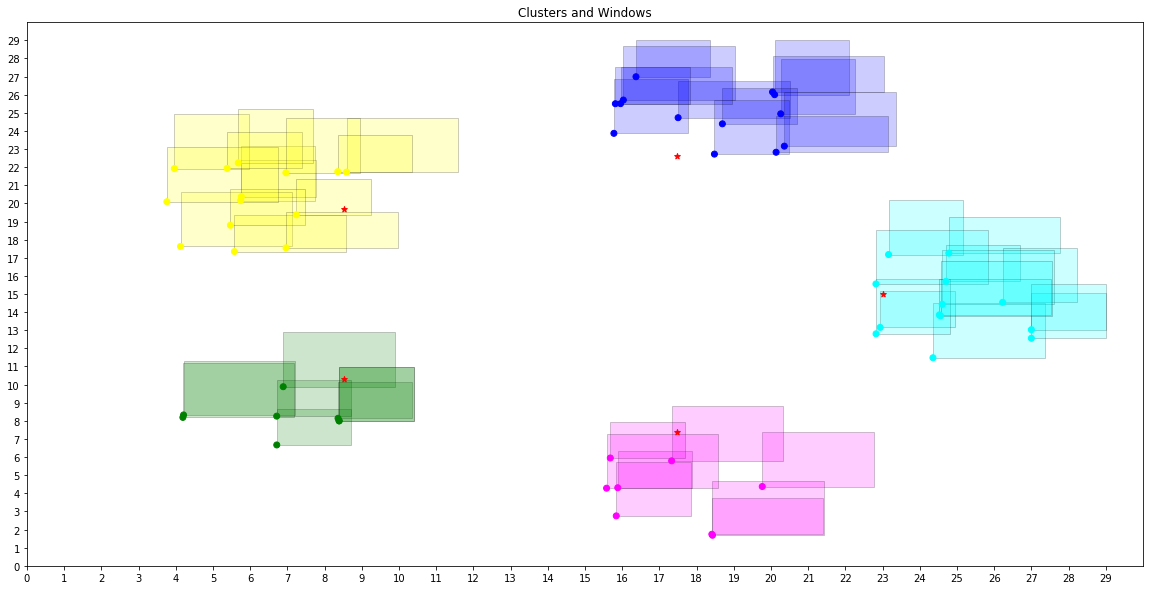

In [14]:
draw_windows(clusters, X_final, points_dims, points[:,4], n_groups, size_groups)

# 5. Elaboração de relatório